# Анализ А/B-теста рекомендательной системы

# Цель
Провести оценку результатов A/B-теста:
* Оценить корректность проведения теста.
* Проанализировать результаты теста.

# Задачи
* Проверить, есть ли пересечение тестовой аудитории с конкурирующим тестом и есть ли пользователи, участвующие в двух группах теста одновременно.
* Проверить равномерность распределения пользователей по тестовым группам и правильность их формирования.


# Техническое задание
* Название теста: `recommender_system_test`;
* Группы: А (контрольная), B (новая платёжная воронка);
* Дата запуска: 2020-12-07;
* Дата остановки набора новых пользователей: 2020-12-21;
* Дата остановки: 2021-01-04;
* Аудитория: 15% новых пользователей из региона EU;
* Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
* Ожидаемое количество участников теста: 6000.
* Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    * конверсии в просмотр карточек товаров — событие `product_page`
    * просмотры корзины — `product_cart`
    * покупки — `purchase`. 
    
Загрузить данные теста, проверить корректность его проведения и проанализировать полученные результаты.

# Описание данных

**`ab_project_marketing_events.csv`** — календарь маркетинговых событий на 2020 год. <br>

Структура файла:

* `name` — название маркетингового события;
* `regions` — регионы, в которых будет проводиться рекламная кампания;
* `start_dt` — дата начала кампании;
* `finish_dt` — дата завершения кампании.
<br><br>

**`final_ab_new_users.csv`** — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.<br>

Структура файла:

* `user_id` — идентификатор пользователя;
* `first_date` — дата регистрации;
* `region` — регион пользователя;
* `device` — устройство, с которого происходила регистрация.
<br><br>

**`final_ab_events.csv`** — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.
<br>

Структура файла:

* `user_id` — идентификатор пользователя;
* `event_dt` — дата и время события;
* `event_name` — тип события;
* `details` — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.
<br><br>

**`final_ab_participants.csv`** — таблица участников тестов.
<br>

Структура файла:

* `user_id` — идентификатор пользователя;
* `ab_test` — название теста;
* `group` — группа пользователя.

# План действий:

**1. Загрузка библиотек и баз данных.** <br> <br>
**2. Просмотр и предобработка (пропуски, дубликаты, типы данных) следующих датасетов:** <br>
    2.1 Датасет ab_project_marketing_events <br>
    2.2 Датасет final_ab_new_users <br>
    2.3 Датасет final_ab_events <br>
    2.4 Датасет final_ab_participants <br>
    2.5 Завершая предобработку. <br>
    2.6 Промежуточный вывод. <br>
    <br>
    
**3. Оценка корректности проведения теста:**<br>
    3.1 Соответствие данных требованиям технического задания. <br>
    3.2 Время проведения теста. Убедимся, что оно не совпадает с маркетинговыми и другими активностями.<br>
    3.3 Аудитория теста. Удостоверимся, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверим равномерность распределения пользователей по тестовым группам.
<br><br>

**4. Исследовательский анализ данных:** <br>
    4.1 Количество событий на пользователя одинаково распределены в выборках? <br>
    4.2 Как число событий в выборках распределено по дням? <br>
    4.3 Как меняется конверсия в воронке в выборках на разных этапах? <br>
    4.4 Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?<br>

**5. Результаты А/В-теста:** <br>
    5.1 Результаты A/B-тестирования, проверка статистической разницы долей z-критерием.<br>

**6. Выводы и общее заключение** <br>
<br>


## Загрузка библиотек и баз данных

In [80]:
# Импортируем библиотеки:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math as mth

import plotly.io as pio 
pio.renderers.default = 'notebook+jupyterlab+png'
pio.renderers['png'].scale = 1.0

import plotly.express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats as st
import datetime as dt
from pandas.plotting import register_matplotlib_converters
import os
import warnings
register_matplotlib_converters()
pd.options.display.float_format = '{:,.2f}'.format
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Загружаем датасеты:

marketing_events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')
new_users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv')
ab_events = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv')
ab_participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv')   

## Просмотр и предобработка датасетов

### Датасет marketing_events

In [3]:
# Отобразим marketing_events:
display(marketing_events)
print()
marketing_events.info()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [4]:
# Явные дубликаты в marketing_events:
marketing_events.duplicated().sum()

0

In [5]:
# Данные в датасете marketing_events в промежутке от:
marketing_events.start_dt.min()

'2020-01-25'

In [6]:
# Данные в датасете marketing_events в промежутке до:
marketing_events.finish_dt.max()

'2021-01-07'

In [7]:
marketing_events.regions.value_counts()

APAC                        4
EU, CIS, APAC, N.America    3
EU, N.America               2
EU, CIS, APAC               2
CIS                         2
N.America                   1
Name: regions, dtype: int64

In [8]:
marketing_events.name.value_counts()

Christmas&New Year Promo            1
St. Valentine's Day Giveaway        1
St. Patric's Day Promo              1
Easter Promo                        1
4th of July Promo                   1
Black Friday Ads Campaign           1
Chinese New Year Promo              1
Labor day (May 1st) Ads Campaign    1
International Women's Day Promo     1
Victory Day CIS (May 9th) Event     1
CIS New Year Gift Lottery           1
Dragon Boat Festival Giveaway       1
Single's Day Gift Promo             1
Chinese Moon Festival               1
Name: name, dtype: int64

In [9]:
len(marketing_events.name.unique())

14

**Комментарий к датасету marketing_events:**
* 14 строк, 4 столбца.
* Типы данных всех столбцов - object. 
* Name и regions можно оставить как object.
* Нужно перевести start_dt и finish_dt в datetime, формат даты и времени.
* Явных дубликатов нет.
* Пропусков нет.
* Данные в диапазоне от 25.01.2020 до 07.01.2021.
* Больше всего маркетинговых событий в регионе ATAC (АТР - Азиатско-Тихоокеанский регион). 
* Среди названий маркетинговых событий мы видим акции к разным праздникам. Всего таких уникальных событий 14. Каждое успели провести по 1 разу.

### Датасет new_users

In [10]:
# Отобразим new_users:
display(new_users)
print()
new_users.info()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
61728,1DB53B933257165D,2020-12-20,EU,Android
61729,538643EB4527ED03,2020-12-20,EU,Mac
61730,7ADEE837D5D8CBBD,2020-12-20,EU,PC
61731,1C7D23927835213F,2020-12-20,EU,iPhone



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [11]:
# Явные дубликаты в new_users:
new_users.duplicated().sum()

0

In [12]:
# Данные new_users начинаются от:
new_users.first_date.min()

'2020-12-07'

In [13]:
new_users.region.value_counts()

EU           46270
N.America     9155
CIS           3155
APAC          3153
Name: region, dtype: int64

In [14]:
new_users.device.value_counts()

Android    27520
PC         15599
iPhone     12530
Mac         6084
Name: device, dtype: int64

**Комментарий к датасету new_users:**
* 61733 строк, 4 столбца.
* Типы данных всех столбцов - object. 
* User_id, region и device можно оставить как object.
* Нужно перевести first_date в datetime, формат даты и времени.
* Явных дубликатов нет.
* Пропусков нет.
* Данные начинаются от 07.12.2020.
* Всего 4 региона: EU (ЕС), N.America (США и Канада), CIS (СНГ), APAC (АТР - Азиатско-Тихоокеанский регион). 
* Больше всего пользователей из EU.
* Всего видов устройств 4: Android, PC, iPhone, Mac. 
* Больше всего пользователей на Android.

### Датасет ab_events

In [15]:
# Отобразим events:
display(ab_events)
print()
ab_events.info()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
...,...,...,...,...
440312,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
440315,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [16]:
# Явные дубликаты в ab_events:
ab_events.duplicated().sum()

0

In [17]:
# Посчитаем, сколько пропусков в столбцах ab_events:
ab_counter = ab_events.isnull().sum()
print(ab_counter)

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64


In [18]:
# Данные ab_events в диапазоне от:
ab_events.event_dt.min()

'2020-12-07 00:00:33'

In [19]:
# Данные ab_events в диапазоне до:
ab_events.event_dt.max()

'2020-12-30 23:36:33'

In [20]:
# События в ab_events:
ab_events.event_name.value_counts()

login           189552
product_page    125563
purchase         62740
product_cart     62462
Name: event_name, dtype: int64

In [21]:
# Детали в ab_events:
ab_events.details.unique()

array([ 99.99,   9.99,   4.99, 499.99,    nan])

In [22]:
# Детали в ab_events:
ab_events.details.value_counts()

4.99      46362
9.99       9530
99.99      5631
499.99     1217
Name: details, dtype: int64

**Комментарий к датасету ab_events:**
* 440 317 строк, 4 столбца.
* Типы данных трех столбцов user_id, event_dt, event_name - object, а столбца details - float64. 
* User_id, event_name  можно оставить как object.
* Нужно перевести event_dt в datetime, формат даты и времени.
* Явных дубликатов нет.
* Пропуски есть в столбце details - 377 577 строк.
* Данные в диапазоне от 07.12.2020 до 30.12.2020.
* Всего 4 уникальных события: login (вход в профиль), product_page (страница продукта), product_cart (продукт в корзине), purchase (покупка).
* Всего 5 деталей в ab_events: 4.9, 9.9, 99.99, 499.99, NaN.

### Датасет ab_participants

In [23]:
# Отобразим ab_participants:
display(ab_participants)
print()
ab_participants.info()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
...,...,...,...
18263,1D302F8688B91781,B,interface_eu_test
18264,3DE51B726983B657,A,interface_eu_test
18265,F501F79D332BE86C,A,interface_eu_test
18266,63FBE257B05F2245,A,interface_eu_test



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


In [24]:
# Явные дубликаты в ab_participants:
ab_participants.duplicated().sum()

0

In [25]:
# Посчитаем, сколько пропусков в столбцах ab_participants:
par_counter = ab_participants.isnull().sum()
print(par_counter)

user_id    0
group      0
ab_test    0
dtype: int64


In [26]:
# Проверим уникальные группы в ab_participants:
ab_participants.group.value_counts()

A    9655
B    8613
Name: group, dtype: int64

In [27]:
# Проверим уникальные результаты в ab_participants:
ab_participants.ab_test.value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

**Комментарий к датасету ab_participants:**
* 18 268 строк, 3 столбца.
* Типы данных трех столбцов user_id, group, ab_test - object, оставим их как есть.
* Явных дубликатов нет.
* Пропусков нет.
* Всего 2 уникальных группы: А и В. Группа А на 12% больше группы В - 9655 против 8613.
* Всего 2 результата в столбце ab_test: recommender_system_test, interface_eu_test. Результатов interface_eu_test почти в 2 раза больше.

### Завершая предобработку:
1. Привести к формату datetime: start_dt и finish_dt в marketing_events, first_date в new_users, event_dt в ab_events. 
2. Решить вопрос с пропусками в датасете ab_events. Пропуски есть в столбце details - 377 577 строк.

#### Приводим к формату datetime

In [28]:
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'], format='%Y-%m-%d')
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'], format='%Y-%m-%d')
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


In [29]:
new_users['first_date'] = pd.to_datetime(new_users['first_date'], format='%Y-%m-%d')
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


**Комментарий:**
    
Столбец event_dt в ab_events отличается от других, т.к. здесь есть данные не только о годе, месяце и дне, но и часы, минуты и секунды.
Такая информация нам не нужна, создадим новый столбец и нормализуем данные, приведем их в соответствие с форматом год-месяц-день.

In [30]:
ab_events['event_dt']

0         2020-12-07 20:22:03
1         2020-12-07 09:22:53
2         2020-12-07 12:59:29
3         2020-12-07 04:02:40
4         2020-12-07 10:15:09
                 ...         
440312    2020-12-30 19:35:55
440313    2020-12-30 10:54:15
440314    2020-12-30 10:59:09
440315    2020-12-30 09:53:39
440316    2020-12-30 11:36:13
Name: event_dt, Length: 440317, dtype: object

In [31]:
ab_events['date'] = pd.to_datetime(ab_events['event_dt']).dt.normalize()
ab_events

,user_id,event_dt,event_name,details,date
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,2020-12-07
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,2020-12-07
...,...,...,...,...,...
440312,245E85F65C358E08,2020-12-30 19:35:55,login,NaN,2020-12-30
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN,2020-12-30
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN,2020-12-30
440315,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN,2020-12-30


#### Пропуски в датасете ab_events в столбце details

In [32]:
#Кол-во значений в столбце details с группировкой по event_name:
ab_events.groupby('event_name').details.count()

event_name
login               0
product_cart        0
product_page        0
purchase        62740
Name: details, dtype: int64

In [33]:
# Детали в ab_events:
ab_events.details.unique()

array([ 99.99,   9.99,   4.99, 499.99,    nan])

In [34]:
# Соберем строки с пропущенными значениями в details в отдельную табличку:
ab_events_sorted = ab_events.loc[ab_events['details'].isna()].sort_values(by='event_name', ascending=False)
ab_events_sorted.head()

,user_id,event_dt,event_name,details,date
204140,BB8D78A288D3D1E3,2020-12-21 12:53:32,product_page,NaN,2020-12-21
146459,997D854249AE2712,2020-12-12 08:58:15,product_page,NaN,2020-12-12
146457,B85C1F7E8F7C0B68,2020-12-12 23:05:12,product_page,NaN,2020-12-12
146456,BF7DCC17FE95D46C,2020-12-12 11:29:58,product_page,NaN,2020-12-12
146455,412AB0DDE6AC3E13,2020-12-12 23:23:25,product_page,NaN,2020-12-12


In [35]:
# Табличку с пропущенными строками проверим по столбцу event_name:
ab_events_sorted.event_name.unique()

array(['product_page', 'product_cart', 'login'], dtype=object)

**Комментарий:**

* Значения в details характерны только для события purchase, т.е. для покупок. Мы видим, как другие значения похожи на цену. <br>
* У всех остальных событий нет значений в столбце details.  <br>
* Пропущенные значения здесь, возможно, являются особенностью сбора данных, следовательно, нет необходимости заменять их на что-либо <br>

### Промежуточный вывод:

В процессе знакомства с данными были даны краткие характеристики каждому датасету:

**I. marketing_events:**
* 14 строк, 4 столбца.
* Типы данных всех столбцов - object. 
* Name и regions можно оставить как object.
* Нужно перевести start_dt и finish_dt в datetime, формат даты и времени.
* Явных дубликатов нет.
* Пропусков нет.
* Данные в диапазоне от 25.01.2020 до 07.01.2021.
* Больше всего маркетинговых событий в регионе ATAC (АТР - Азиатско-Тихоокеанский регион). 
* Среди названий маркетинговых событий мы видим акции к разным праздникам. Всего таких уникальных событий 14. Каждое успели провести по 1 разу.


**II. new_users:**
* 61733 строк, 4 столбца.
* Типы данных всех столбцов - object. 
* User_id, region и device можно оставить как object.
* Нужно перевести first_date в datetime, формат даты и времени.
* Явных дубликатов нет.
* Пропусков нет.
* Данные начинаются от 07.12.2020.
* Всего 4 региона: EU (ЕС), N.America (США и Канада), CIS (СНГ), APAC (АТР - Азиатско-Тихоокеанский регион). 
* Больше всего пользователей из EU.
* Всего видов устройств 4: Android, PC, iPhone, Mac. 
* Больше всего пользователей на Android.


**III. ab_events:**
* 440 317 строк, 4 столбца.
* Типы данных трех столбцов user_id, event_dt, event_name - object, а столбца details - float64. 
* User_id, event_name  можно оставить как object.
* Нужно перевести event_dt в datetime, формат даты и времени.
* Явных дубликатов нет.
* Пропуски есть в столбце details - 377 577 строк.
* Данные в диапазоне от 07.12.2020 до 30.12.2020.
* Всего 4 уникальных события: login (вход в профиль), product_page (страница продукта), product_cart (продукт в корзине), purchase (покупка).
* Всего 5 деталей в ab_events: 4.9, 9.9, 99.99, 499.99, NaN.


**IV. ab_participants:**
* 18 268 строк, 3 столбца.
* Типы данных трех столбцов user_id, group, ab_test - object, оставим их как есть.
* Явных дубликатов нет.
* Пропусков нет.
* Всего 2 уникальных группы: А и В. Группа А на 12% больше группы В - 9655 против 8613.
* Всего 2 результата в столбце ab_test: recommender_system_test, interface_eu_test. Результатов interface_eu_test почти в 2 раза больше.

<hr> 

**Также были выявлены следующие проблемы:**
1. Некорректный тип предоставления данных - object вместо формата datetime: start_dt и finish_dt в marketing_events, first_date в new_users, event_dt в ab_events.
2. Пропуски в датасете ab_events в столбце details - 377 577 строк.


**Была проведена предобработка:**
1. Тип данных изменён на datetime в следующих столбцах датафреймов:
* marketing_events - start_dt и finish_dt;
* new_users - first_date;
* ab_events - event_dt.
* В датафрейм ab_events добавлен столбец date с датой в формате datetime.

2. Была исследована природа пропусков, они оставлены без изменений. 

В процессе предобработки явных аномалий и дубликатов замечено не было. Можно приступить к исследованию полученных данных.

## Оценка корректности проведения теста

### Соответствие данных требованиям технического задания. 
Проверьте корректность всех пунктов технического задания.

**Пункт 1. Название теста: `recommender_system_test`**

In [36]:
#Подсчитаем значения столбца ab_test в датасете ab_participants:
ab_participants.ab_test.value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

В датасете два вида A/B-тестов: recommender_system_test (рекомендательной системы) и interface_eu_test (тест интерфейса в ЕС). 
Сохраним нужный нам тест отдельно в part_rec_test:

In [37]:
part_rec_test = ab_participants.query('ab_test == "recommender_system_test"')
part_rec_test.head(10)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
5,4FF2998A348C484F,A,recommender_system_test
6,7473E0943673C09E,A,recommender_system_test
7,C46FE336D240A054,A,recommender_system_test
8,92CB588012C10D3D,A,recommender_system_test
9,057AB296296C7FC0,B,recommender_system_test


**Пункт 2. Группы: А (контрольная), B (новая платёжная воронка)**

In [38]:
part_rec_test.group.value_counts()

A    3824
B    2877
Name: group, dtype: int64

In [39]:
diff = part_rec_test.query('group == "A"').group.count() - part_rec_test.query('group == "B"').group.count()
print('Разница между группами: {} чел.'.format(diff))

Разница между группами: 947 чел.


**Комментарий:** <br>
В нашей выборке для теста рекомендательной системы действительно есть А и В группы, но они представлены не равномерно. Группа А больше группы В на 947 человек. Но, учитывая что сравнивать придется относительные показатели, влияние разницы в размере групп на результаты A/B-теста значимым не будет.

**Пункт 3. Дата запуска: 2020-12-07**

Данные имеются в датасете ab_events в столбце date.

In [40]:
print('Дата запуска теста:', ab_events.date.min())

Дата запуска теста: 2020-12-07 00:00:00


Дата запуска теста **соответствует ТЗ.**

**Пункт 4. Дата остановки набора новых пользователей: 2020-12-21**

Данные имеются в датасете new_users в столбце first_date.

Так как в наших датасетах содержатся данные по двум тестам, проводимым одновременно, отфильтруем new_users и объединим их с участниками нужного теста - part_rec_test.

In [41]:
nu_rec_test = part_rec_test.merge(new_users, on='user_id', how='left')
nu_rec_test.head()

,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone
2,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac
3,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone
4,482F14783456D21B,B,recommender_system_test,2020-12-14,EU,PC


In [42]:
# Дата остановки набора новых пользователей:
print('Дата остановки набора новых пользователей:', nu_rec_test.first_date.max())

Дата остановки набора новых пользователей: 2020-12-21 00:00:00


Дата остановки набора новых пользователей **соответствует ТЗ.**

**Пункт 5. Дата остановки: 2021-01-04**

Данные имеются в датасете ab_events в столбце date

In [43]:
# Данные в датасете marketing_events в промежутке до:
print('Дата остановки теста:', ab_events.date.max())

Дата остановки теста: 2020-12-30 00:00:00


Дата остановки теста **не соответствует ТЗ.**

In [44]:
real_duration = pd.Timedelta(ab_events.date.max() - ab_events.date.min())
print('Реальная продожительность A/B-теста: {}'.format(real_duration))

Реальная продожительность A/B-теста: 23 days 00:00:00


Длительность теста должна была составить 28 дней, и все участники теста должны были прожить минимум 14 дней с момента регистрации.

Но так как тест остановили на 5 дней раньше, то это условие нарушено, и часть действий пользователей в горизонт анализа уже не попадёт.

**Пункты 6 и 8. Аудитория: 15% новых пользователей из региона EU. Ожидаемое количество участников теста: 6000**

Т.е. новых участников (из датасета new_users) должно было 900 и более человек.

In [45]:
users_EU = (nu_rec_test.query('region == "EU"').user_id.count())

print('Количество участников теста из ЕС: {}'.format(users_EU))

Количество участников теста из ЕС: 6351


In [46]:
print('Участников A/B-теста из ЕС: {:.1%}'.format(users_EU / new_users.query('region=="EU"').user_id.count()))

Участников A/B-теста из ЕС: 13.7%


* Ожидаемое количество участников теста **соответствует ТЗ.**
* Процентное соотношение новых пользователей из EU **не соответствует ТЗ.**

**Пункт 7. Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы**
Выше мы уже обнаружили, что в датасете ab_participants были представлены участники двух тестов.

Мы уже выделили участников нашего теста recommender_system_test в part_rec_test и присоединили к получившемся датасету табличку new_users, назвав все это nu_rec_test.

Теперь данные **соответствуют ТЗ.**

In [47]:
nu_rec_test

,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone
2,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac
3,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone
4,482F14783456D21B,B,recommender_system_test,2020-12-14,EU,PC
...,...,...,...,...,...,...
6696,053FB26D6D49EDDC,A,recommender_system_test,2020-12-10,N.America,Android
6697,9D263B8EF15CF188,B,recommender_system_test,2020-12-16,N.America,Mac
6698,F2FBBA33F37DEC46,A,recommender_system_test,2020-12-18,APAC,Mac
6699,29C92313A98B1176,B,recommender_system_test,2020-12-07,APAC,Android


### Время проведения теста. 

Результаты теста могли исказить активности не только в сам период теста (с 07.12.20 по 04.01.21), но и начавшиеся или закончившиеся чуть раньше или позже нашего теста, но частично совпавшие со временем его проведения. 

In [48]:
# Отберем в календаре маркетинговые события, хотя бы частично совпадающие по датам с тестом:
marketing_events.query ('start_dt > "2020-12-07" or finish_dt > "2020-12-07"')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Поскольку тест был развернут на аудиторию из ЕС (EU), нас интересует только 1 маркетинговая активность - Christmas&New Year Promo. 

Акция проходила с 25.12.20 по 03.01.21, а наш тест - с 07.12.20 по 04.01.21, т.е. акция могла повлиять на пользователей и исказить результаты теста.

### Аудитория теста. 

Необходимо уточнить количество пользователей, попавших сразу в оба теста: recommender_system_test и interface_eu_test.

Также нужно узнать, как эти пользователи распределены между группами в нашем тесте (recommender_system_test).

In [49]:
# Найдем пользователей, попавших в оба теста:

duplicates = ab_participants[ab_participants['user_id'].duplicated(keep=False)==True]
duplicates = duplicates.sort_values(by='user_id', ascending=True)
display(duplicates)
print(len(duplicates)/2)

,user_id,group,ab_test
17892,001064FEAAB631A1,B,interface_eu_test
235,001064FEAAB631A1,B,recommender_system_test
16961,00341D8401F0F665,A,interface_eu_test
2137,00341D8401F0F665,A,recommender_system_test
8143,003B6786B4FF5B03,A,interface_eu_test
...,...,...,...
5213,FFC53FD45DDA5EE8,B,recommender_system_test
5667,FFED90241D04503F,B,recommender_system_test
14158,FFED90241D04503F,B,interface_eu_test
3448,FFF28D02B1EACBE1,B,recommender_system_test


1602.0


Такие пользователи действительно есть. Судя по строкам, их 1602 человека.

Проверим, как они распределены по группам нашего теста.

In [50]:
duplicates[duplicates['ab_test']=='recommender_system_test']['group'].value_counts()

A    921
B    681
Name: group, dtype: int64

Большая часть дублируемых пользователей приходится на группу А, но в группе В их тоже немало.
Узнаем, какую долю от всех пользователей в каждой группе занимают дублируемые пользователи:

In [51]:
nu_rec_test.group.value_counts()

A    3824
B    2877
Name: group, dtype: int64

In [52]:
dup_a = duplicates.query (
    'ab_test == "recommender_system_test" & group == "A"')['user_id'].count() /  nu_rec_test[nu_rec_test['group']=='A']['user_id'].nunique() * 100
dup_a = dup_a.round(1)  

dup_b = duplicates.query (
    'ab_test == "recommender_system_test" & group == "B"')['user_id'].count() / nu_rec_test[nu_rec_test['group']=='B']['user_id'].nunique() * 100

dup_b = dup_b.round(1) 
    
print ('В группе А дублируемые пользователи составляют: {}%'.format(dup_a))
print ('В группе B дублируемые пользователи составляют: {}%'.format(dup_b))


В группе А дублируемые пользователи составляют: 24.1%
В группе B дублируемые пользователи составляют: 23.7%


Итак, дублируемые пользователи распределены по А и В группам нашего теста примерно равномерно - это чуть меньше четверти всех пользователей.
Конечно, в будущем следует избегать подобных пересечений тестов, особенно в период Рождества и Нового года, но в данном случае мы не можем выкинуть из нашего теста почти четверть исследуемых. 

Принято решение оставить как есть, уточнив у коллег из отдела маркетинга детали насчет второго теста. Возможно, его влияние не было столь сильным.

## Исследовательский анализ данных

Перед началом исследования завершим объединение нужных нам данных из трех датасетов.

Ранее мы уже объединили ab_participants, которые участвовали в recommender_system_test, вместе с датасетом new_users, и получился nu_rec_test.

Теперь объединим nu_rec_test с ab_events.

In [53]:
# data - полный датасет для исследования, только с участниками целевого теста:
data = (nu_rec_test.merge(ab_events, on='user_id', how='left'))
data.head()

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,date
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99,2020-12-07
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:56,purchase,4.99,2020-12-25
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN,2020-12-07
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:57,product_cart,NaN,2020-12-25
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,NaN,2020-12-07


In [54]:
# На всякий случай проверим количество дубликатов:
data.duplicated().sum()

0

In [55]:
# Проверим количество строк и типы данных:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27724 entries, 0 to 27723
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     27724 non-null  object        
 1   group       27724 non-null  object        
 2   ab_test     27724 non-null  object        
 3   first_date  27724 non-null  datetime64[ns]
 4   region      27724 non-null  object        
 5   device      27724 non-null  object        
 6   event_dt    24698 non-null  object        
 7   event_name  24698 non-null  object        
 8   details     3331 non-null   float64       
 9   date        24698 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(7)
memory usage: 2.3+ MB


В сводном датасете появились пропуски в столбцах event_dt, event_name, date. 

Пропуски в details уже были прежде.

Отобразим строки с пропусками в event_dt и event_name, чтобы лучше понять их происхождение.

In [56]:
losses = data.query('event_dt.isna() & event_name.isna()').sort_values(by='user_id', ascending=True)
losses

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,date
24080,000ABE35EE11412F,A,recommender_system_test,2020-12-08,EU,PC,NaN,NaN,NaN,NaT
3101,001C05E87D336C59,A,recommender_system_test,2020-12-10,EU,iPhone,NaN,NaN,NaN,NaT
13055,003B6786B4FF5B03,A,recommender_system_test,2020-12-13,EU,Android,NaN,NaN,NaN,NaT
20732,006D4BE0C4EA616F,B,recommender_system_test,2020-12-10,EU,PC,NaN,NaN,NaN,NaT
25572,007B7DE3A2E44050,B,recommender_system_test,2020-12-21,EU,iPhone,NaN,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...
2805,FFB3F647898BA928,B,recommender_system_test,2020-12-13,EU,PC,NaN,NaN,NaN,NaT
3955,FFC2C5F898D1245B,B,recommender_system_test,2020-12-10,EU,Android,NaN,NaN,NaN,NaT
21769,FFC53FD45DDA5EE8,B,recommender_system_test,2020-12-19,EU,iPhone,NaN,NaN,NaN,NaT
17185,FFE858A7845F005E,A,recommender_system_test,2020-12-08,EU,PC,NaN,NaN,NaN,NaT


In [57]:
#Всего уникальных пользователей в нашем сводном датасете data:
users_in_data = len(data.user_id.unique())     
users_in_data

6701

In [58]:
#Уникальных пользователей с пропущенными значениями в losses из data:
users_in_losses = len(losses.user_id.unique())    
share = round(((users_in_losses / users_in_data)*100),1)

print("Уникальных пользователей в пропусках: {}".format(users_in_losses))
print("Доля от всех пользователей сводного датасета data: {}".format(share))

Уникальных пользователей в пропусках: 3026
Доля от всех пользователей сводного датасета data: 45.2


**Комментарий:** <br>
Пользователи в пропусках (losses) не повторяются.
Можем предположить, что данные пользователи зарегистрировались, попали в наш тест, но никаких действий за время его проведения не совершили, поэтому и нет информации в столбцах event_dt и event_name. 

И таких неактивных пользователей - 3026 из 6701 или 45,2%.
Для удобства выделим их в табличку inactive и изучим внимательнее:

In [59]:
inactive = data.query('event_dt.isna() & event_name.isna()')
inactive.group.value_counts()

B    1949
A    1077
Name: group, dtype: int64

В группе B неактивных пользователей почти в 2 раза больше, чем в группе А. 

Для наглядности построим график динамики неактивных пользователей в каждой группе по дням:

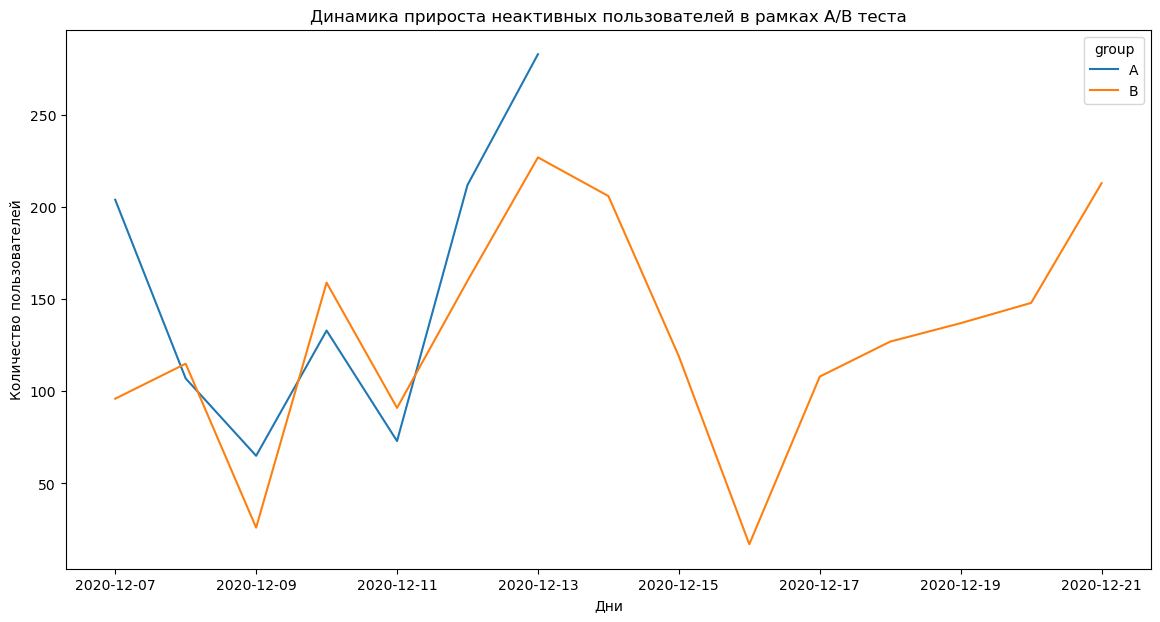

In [60]:
plt.figure(figsize=(14,7))
inactive_by_day = (inactive.groupby(['first_date', 'group']).agg({'user_id': 'count'}).reset_index())
with sns.color_palette("tab10"):
    sns.lineplot(data=inactive_by_day, y='user_id', x='first_date', hue ='group')
plt.title('Динамика прироста неактивных пользователей в рамках А/В теста')
plt.xlabel('Дни')
plt.ylabel('Количество пользователей')
plt.show()

Комментарий:
Само по себе наличие неактивных пользователей абсолютно естественно. Смутила именно большая разница между группами А и В. 

График подтверждает аномалию и демонстрирует, как с 07.12.20 по 12.12.20 динамика прироста неактивных пользователей двух групп была более-менее равномерной.

13.12. что-то приозошло, и в группе А перестали появляться неактивные пользователи, в то время как в группе В их приток продолжался.

Можем предположить, что причина носит технический характер - либо часть данных при выгрузке была утеряна, либо у всех пользователей из обеих групп были некие трудности с регистрацией или дальнейшим отображением сайта, но 13.12 для группы А эти проблемы решили, а для группы В - нет.

В любом случае, учитывая явную аномалию данной ситуации, нам **необходимо исключить неактивных пользователей из датасета data** во избежание искажения результатов теста:

In [61]:
#Исключаем неактивных пользователей из теста во избежание его искажения:
inactive_filter = inactive.user_id.to_list()
data = data.query('not user_id in @inactive_filter')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24698 entries, 0 to 27723
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     24698 non-null  object        
 1   group       24698 non-null  object        
 2   ab_test     24698 non-null  object        
 3   first_date  24698 non-null  datetime64[ns]
 4   region      24698 non-null  object        
 5   device      24698 non-null  object        
 6   event_dt    24698 non-null  object        
 7   event_name  24698 non-null  object        
 8   details     3331 non-null   float64       
 9   date        24698 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(7)
memory usage: 2.1+ MB


Итак, мы избавились от пропусков во всех столбцах кроме известного нам details. <br>
Теперь количество строк - 24 698. <br>
Можно приступать к исследованию. <br>

### Количество событий на пользователя одинаково распределены в выборках?

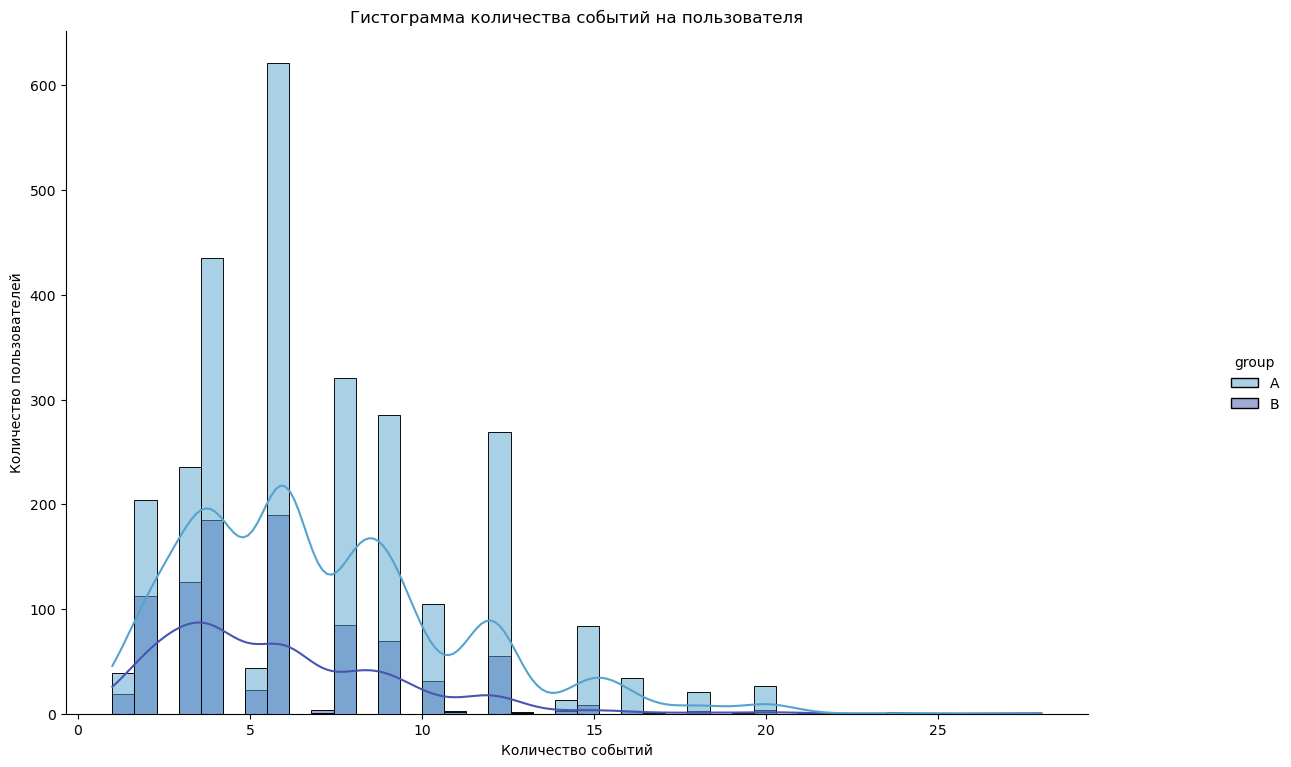

In [62]:
# Отобразим распределение события по пользователям с учетом групп А и В:
plot_data_user = data.groupby(['group', 'user_id']).agg({'event_name': 'count'}).reset_index()

with sns.color_palette("icefire"):
    plot = sns.displot(plot_data_user, x='event_name', hue='group', kde=True)
plt.title('Гистограмма количества событий на пользователя')
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей')
plot.fig.set_figwidth(14)
plot.fig.set_figheight(8)
plt.show()

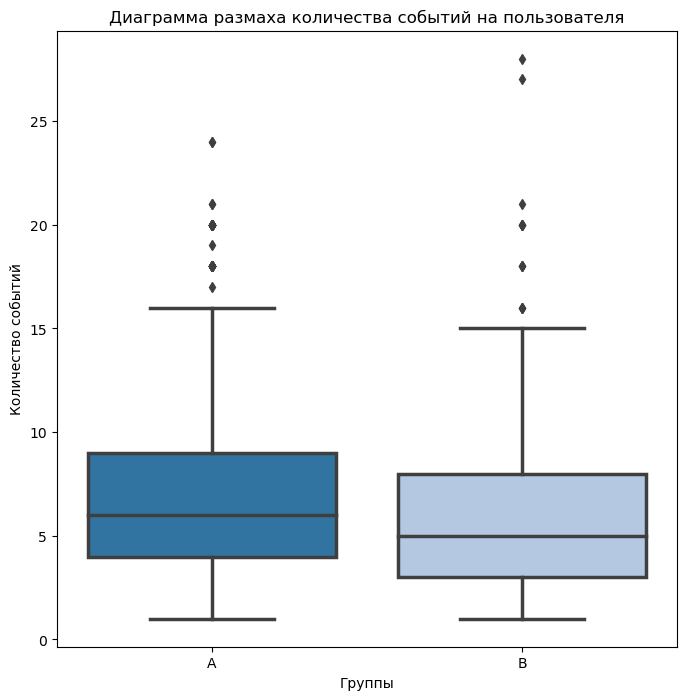

In [63]:
plt.figure(figsize=(8,8))
sns.boxplot(x='group', y='event_name', data=plot_data_user, palette='tab20', linewidth=2.5)
plt.title('Диаграмма размаха количества событий на пользователя')
plt.xlabel('Группы')
plt.ylabel('Количество событий')
plt.show()

In [64]:
min_b = plot_data_user['event_name'].min()
std_b = round(plot_data_user['event_name'].std(), 1)
mean_b = round(plot_data_user['event_name'].mean(), 2)
median_b = plot_data_user['event_name'].median()
max_b = plot_data_user['event_name'].max()

print('Для всех участников теста количество событий min: {}, std: {}, mean: {}, median: {}, sum: {}.'.format(min_b, std_b, mean_b, median_b, max_b))

Для всех участников теста количество событий min: 1, std: 3.8, mean: 6.72, median: 6.0, sum: 28.


In [65]:
data.group.value_counts()

A    19304
B     5394
Name: group, dtype: int64

**Комментарий:**
* В группе А больше всего пользователей совершает 6 событий.
* В группе В пользователи совершают чаще всего или 4, или 6 событий.
* Среднее арифметическо количество событий по обеим группам - 6,72, а медиана - 6.
* Активность в группе В в целом ниже, чем в группе А. Скорее всего, из-за того, что группа В меньше по количеству.
* В обеих группах есть аномально высокая активность у части пользователей - 15 событий на пользователя и больше. Особенно в группе В, как это демонстрирует диаграмма размаха.

### Как число событий в выборках распределено по дням?

In [66]:
#Сначала сгруппируем данные для гистограммы по группам и дням:
plot_data_day = data.groupby(['group', 'event_dt']).agg({'event_name': 'count'}).reset_index()
plot_data_day

,group,event_dt,event_name
0,A,2020-12-07 00:14:01,2
1,A,2020-12-07 00:16:00,3
2,A,2020-12-07 00:31:08,2
3,A,2020-12-07 00:35:15,2
4,A,2020-12-07 00:39:13,1
...,...,...,...
16542,B,2020-12-29 23:24:34,1
16543,B,2020-12-29 23:27:00,1
16544,B,2020-12-30 06:42:52,2
16545,B,2020-12-30 12:42:56,1


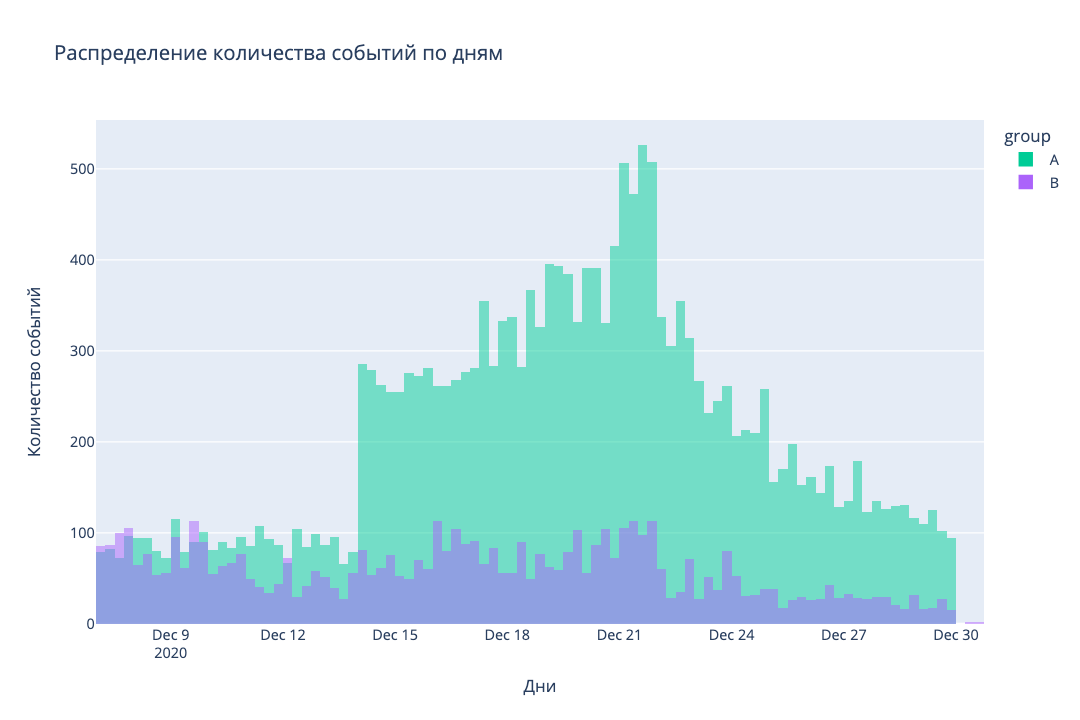

In [81]:
# Строим гистограмму:
fig = px.histogram(plot_data_day, x='event_dt', y='event_name', color="group", color_discrete_map = {0:'#abd0de',1:'#ed6c34'}, opacity=0.5, 
                   width=1000, height=600, title="Распределение количества событий по дням", barmode='overlay')
fig.update_layout(xaxis_title='Дни',
                   yaxis_title='Количество событий') 
pio.show(fig, renderer='png', width=900, scale=1.2)

**Комментарии:**
* В группе А наблюдается резкий рост активности с 14 декабря.
* Пик активности группы А пришелся на 20-21 декабря.
* Активность группы В более-менее равномерна на протяжении всего теста.
* В целом активность группы В существенно ниже группы А.

Можно было бы сказать, что причина резкого скачка активности - в рождественском ажиотажном спросе, но тогда выросли бы показатели и группы В. 

Для поиска причины такого роста взглянем на динамику регистрации новых пользователей в группах.
Возможно, в группе А вдруг оказалось много новых и активных пользователей.

In [68]:
#Собираем табличку для новой гистограммы - с новыми пользователями и их регистрациями по дням:
plot_data_new_users = data.groupby(['group', 'first_date']).agg({'user_id': 'nunique'}).reset_index()
plot_data_new_users['first_date'] = plot_data_new_users['first_date'].astype(object)
plot_data_new_users['first_date'] = plot_data_new_users['first_date'].astype(str).str[:-8].astype(object)
plot_data_new_users.head()

,group,first_date,user_id
0,A,2020-12-07,163
1,A,2020-12-08,98
2,A,2020-12-09,82
3,A,2020-12-10,66
4,A,2020-12-11,92


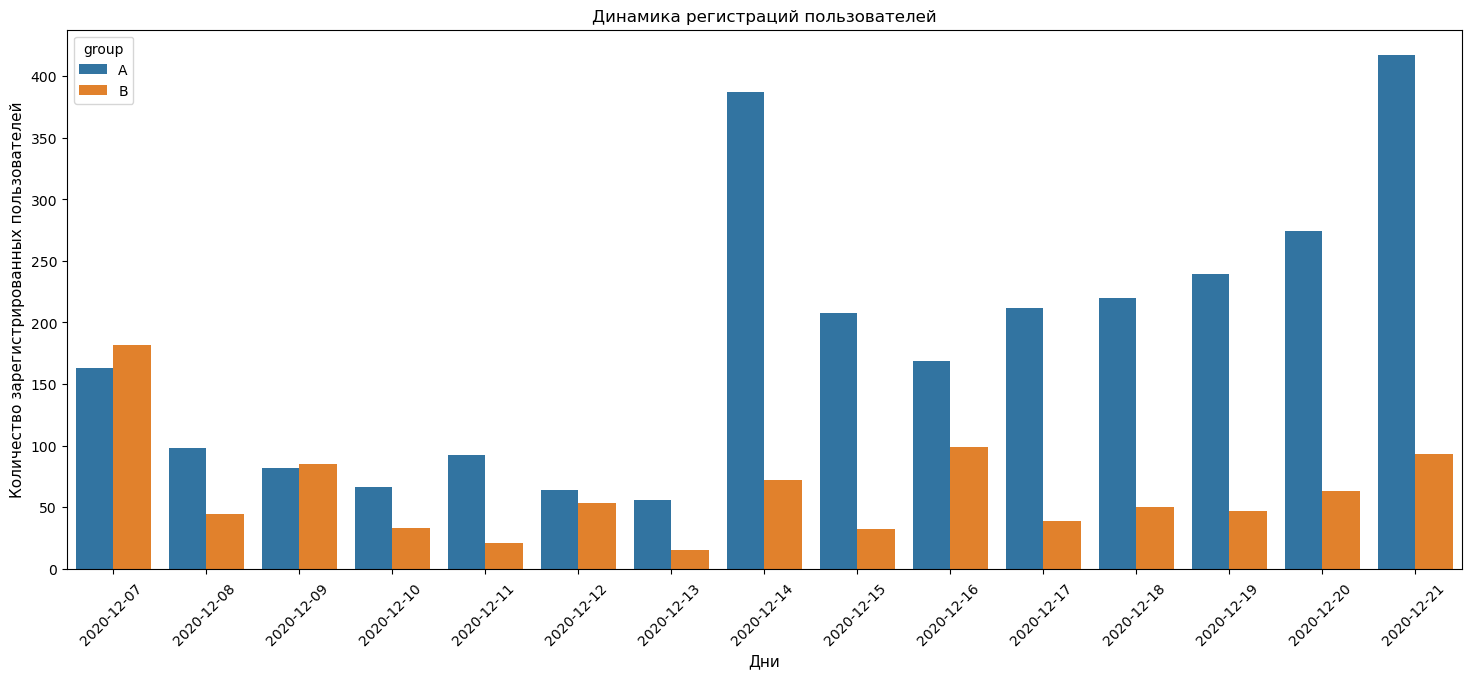

In [69]:
import matplotlib.dates as mdates

#Строим гистограмму с динамикой регистрации новых пользователей по дням:
plt.figure(figsize=(18,7))
sns.barplot(data=plot_data_new_users, x='first_date', y='user_id', hue='group', ci=None)
plt.title('Динамика регистраций пользователей')
plt.xlabel("Дни", size = 11)
plt.xticks(rotation=45)
plt.ylabel("Количество зарегистрированных пользователей", size = 11)
plt.show()

**Комментарий:**
* Всплеск активности группы А с 14 декабря объясняется таким же резким скачком регистраций новых пользователей в этой группе, начиная с 14 декабря и далее.
* Похоже, снова была допущена техническая ошибка при делении пользователей на группы для А/В-теста, которая явно повлияет на его результаты. К сожалению, исправить эту ошибку сейчас уже невозможно.

### Как меняется конверсия в воронке в выборках на разных этапах?

Рассмотрим события не только по группам А и В, но и по этапам воронки, которую сейчас построим, исходя из полученных выше данных.

**Наша воронка продаж состоит из 4 этапов:**

1. `login` - авторизация пользователя
2. `product_page` - просмотр карточки товара
3. `product_cart` - просмотр корзины
4. `purchase` - покупка.

In [70]:
# Добавим в таблицу столбец с информацией о количестве дней с момента регистрации:
data['event_dt'] = pd.to_datetime(data['event_dt']).dt.normalize()
data['first_date'] = pd.to_datetime(data['first_date']).dt.normalize()

data['days'] = data['event_dt'] - data['first_date']
data = data.sort_values(by='days', ascending=False)

# Сохраним в датасете только те события, которые произошли в течение 14 дней с момента регистрации пользователя:
data = data[data['days']<='14 days']
data.head()

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,date,days
12383,10863662C3B5AB49,B,recommender_system_test,2020-12-09,EU,Android,2020-12-23,product_page,NaN,2020-12-23,14 days
11261,AF34780719AA1BA3,B,recommender_system_test,2020-12-12,EU,PC,2020-12-26,product_page,NaN,2020-12-26,14 days
18956,75062DC10C9CC2A3,A,recommender_system_test,2020-12-15,EU,PC,2020-12-29,login,NaN,2020-12-29,14 days
18954,75062DC10C9CC2A3,A,recommender_system_test,2020-12-15,EU,PC,2020-12-29,product_page,NaN,2020-12-29,14 days
4286,9D7F535B9A8DE4F0,B,recommender_system_test,2020-12-09,EU,Android,2020-12-23,login,NaN,2020-12-23,14 days


In [71]:
# Начнем строить таблицу-воронку для группы А:
funnel_A = (data.query('group == "A"').groupby('event_name')
            .agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False))

funnel_A

,user_id
event_name,
login,2747
product_page,1780
purchase,872
product_cart,824


In [72]:
# Начнем строить таблицу-воронку для группы B:
funnel_B = (data.query('group == "B"').groupby('event_name')
            .agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False))

funnel_B

,user_id
event_name,
login,927
product_page,523
purchase,256
product_cart,255


**Комментарий:** <br>
Во двум воронкам видно, что некоторые оформляют покупку непосредственно со страницы продукта, не заходя корзину. <br>
Поэтому на шаге purchase пользователей больше, чем в product_cart. <br>
Отсортируем по порядку:<br>

In [73]:
funnel_A = funnel_A.reindex(['login', 'product_page', 'product_cart', 'purchase'])
funnel_B = funnel_B.reindex(['login', 'product_page', 'product_cart', 'purchase'])
display(funnel_A)
display(funnel_B)

,user_id
event_name,
login,2747
product_page,1780
product_cart,824
purchase,872


,user_id
event_name,
login,927
product_page,523
product_cart,255
purchase,256


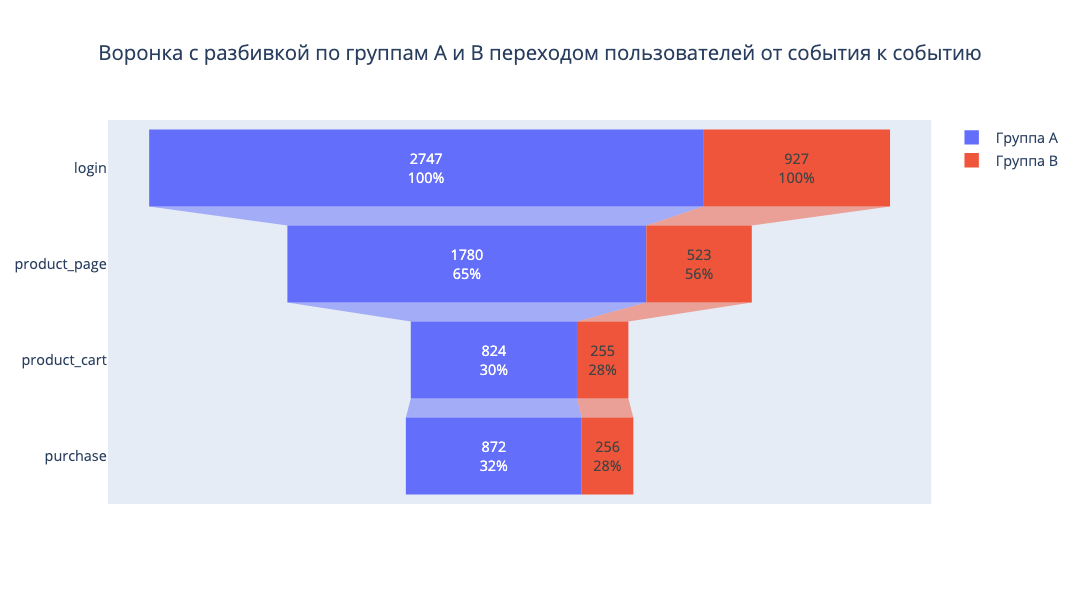

In [82]:
# Построим воронку продаж с разбивкой по группам А и В и отображением в % перехода с этапа на этап:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Группа А',
    y = funnel_A.index,
    x = funnel_A.user_id.values,
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'Группа B',
    orientation = "h",
    y = funnel_B.index,
    x = funnel_B.user_id.values,
    textposition = "inside",
    textinfo = "value+percent initial"))

fig.update_layout(title_text='Воронка с разбивкой по группам А и В переходом пользователей от события к событию', title_x=0.5)
pio.show(fig, renderer='png', width=900, scale=1.2)

**Вывод:**<br>
* Из 100% зарегистрировавшихся пользователей до покупки доходят 32% в группе А и 28% в группу В.
* Самые большие потери на двух этапах:
    * от этапа регистрации до карточки товара (login -> product_page) мы теряем 35% из группы А и 44% из группы В. 
    * от карточки товара до перехода в корзину (product_page -> product_cart) мы теряем еще 35% из группы А и 29% из группы В.
* Зато успешную покупку совершают чуть больше, чем переходящие в корзину.
* Тем не менее, результаты у воронки группы В даже хуже, чем у группы А, хотя предполагался иной исход.

**Согласно ТЗ**, за 14 дней с момента регистрации в системе пользователи должны были показать улучшение каждой метрики не менее, чем на 10%:
product_page, product_cart, purchase.

**Согласно воронке** product_page упала на 9% - с 65 до 56 (между группами), product cart - на 3%, а purchase - на 4%.

### Особенности данных, оказывающие влияние на А/В-тестирование

Прежде чем провести анализ А/В-теста, повторим найденные особенности данных, оказывающие влияние на результат:

**1. Неравномерная выборка в группы А и В.**

Изначально в участниках теста оказалось 6701 чел.  <br>
Из них в группе А - 3824 чел., в группе В - 2877 чел.  <br>
То есть группа А больше группы В на 947 человек.  <br>

Далее было обнаружено 3026 неактивных пользователей. Из них 1077 из группы А и 1949 из группы В.  <br>
В силу технических причин с 13 декабря в группе А перестали появляться неактивные пользователи, в то время как в группе В их приток продолжался. <br> <br>
Нам пришлось исключить неактивных пользователей из датасета data во избежание искажения результатов теста, и перекос в сторону увеличения группы А по сравнению с группой В, к сожалению, усилился.


**2. Укороченная длительность теста.**  

Длительность теста должна была составить 28 дней, и все участники теста должны были *прожить* минимум 14 дней с момента регистрации.
Но так как тест остановили на 5 дней раньше, то это условие оказалось нарушено.

**3. Риск влияния маркетинговых кампаний**

Тест совпал по времени с рождественской и новогодней активностью - Christmas&New Year Promo с 25.12.20 по 03.01.21. А тест проходил с 07.12.20 по 30.12.20 (по факту). Акция могла повлиять на пользователей и исказить результаты теста.  <br>

**4. Пересекающиеся пользователи из другого теста** 

1602 человека попали сразу в оба теста: recommender_system_test и interface_eu_test.
В группе А дублируемые пользователи составили 24.1% от всей группы (921 из 3824), в группе B - 23.7% от всей группы (681 из 2877).
Дублируемых в двух тестах пользователей удалять не стали, оставили как есть.

**5. Резкий скачок активности в группе А в середине теста**

Резкий скачок активности в группе А с 14 декабря связан с не менее аномальным ростом регистрации новых пользователей.
К сожалению, узнать причины этого явления с текущими данными нельзя.

Резюмируя: ожидаемый в ТЗ результат - увеличение конверсии на всех событиях не менее, чем на 10% - маловероятен.

## Результаты A/B-теста

Проверим гипотезы о равенстве долей при помощи z-теста.
Посчитаем доли пользователей, совершивших то или иное событие от числа пользователей на шаге входа на сайт (login), и проверим статистическую значимость отличий.

Установим нулевую и альтернативную гипотезы:

Н0 - Нет различий между группами А и B.

Н1 - Есть различия между группами А и B. 

Напишем функцию для отрисовки таблицы с результатами теста.

### Результаты A/B-тестирования, проверка статистической разницы долей z-критерием


In [75]:
# Готовим данные для теста:
ab_test_result = data.pivot_table(index='event_name', values='user_id', columns='group', aggfunc='nunique')                                    
ab_test_result

group,A,B
event_name,,
login,2747,927
product_cart,824,255
product_page,1780,523
purchase,872,256


In [84]:
# Пишем функцию для расчета конверсии
def conversion (group1, event1, group2, event2):

    # уровень альфа:
    alpha = 0.05/3

    # считаем количество человек на каждом из двух шагов для первой группы:
    first_group1 = ab_test_result.query ('event_name==@event1')[group1][0]
    second_group1 = ab_test_result.query ('event_name==@event2')[group1][0]
    
    # считаем количество человек на каждом из двух шагов для второй группы:
    first_group2 = ab_test_result.query ('event_name==@event1')[group2][0]
    second_group2 = ab_test_result.query ('event_name==@event2')[group2][0]
    
    #  соотношение доли к общему в первой группе:
    conversion_first = second_group1 / first_group1
    print ('Конверсия для группы', group1, ':', conversion_first)
    
    #соотношение доли к общему во второй группе:
    conversion_second = second_group2 / first_group2
    print ('Конверсия для группы', group2, ':', conversion_second)

    # соотношение доли к общему в сумме:
    c_combined = (second_group1+second_group2)/(first_group1+first_group2)

    # разница соотношений:
    difference = conversion_first - conversion_second

    # z-критерий:
    z_value = difference / mth.sqrt(c_combined * (1 - c_combined) * (1/first_group1 + 1/first_group2))
    
    #распределение
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-value: ', p_value)

    if p_value < alpha:
        print('Ho отвергаем. Между группами есть статзначимая разница.')
    else:
        print(
        'Не получилось отвергнуть Ho, между группами нет статзначимой разницы.') 

#### Конверсия в просмотр карточки товара (login -> product_page)

Cформулируем гипотезы:

**Нулевая гипотеза Ho:** различий в конверсии в просмотр карточки товара между группами А и В нет. <br>
**Альтернативная гипотеза H1:** различия между группами А и В есть.

In [77]:
# Вызываем функцию conversion для расчета конверсии и уровня статразницы между первым и вторым этапами:
conversion ('A', 'login', 'B', 'product_page')

Конверсия для группы A : 0.6479796141244994
Конверсия для группы B : 0.564185544768069
p-value:  5.084368080776613e-06
Ho отвергаем. Между группами есть статзначимая разница.


#### Конверсия в просмотр корзины (product_page -> product_cart)

Cформулируем гипотезы:

**Нулевая гипотеза Ho:** различий в конверсии в просмотр корзины между группами А и В нет. <br>
**Альтернативная гипотеза H1:** различия между группами А и В есть.

In [78]:
# Вызываем функцию conversion для расчета конверсии и уровня статразницы между вторым и третьим этапами:
conversion ('A', 'product_page', 'B', 'product_cart')

Конверсия для группы A : 0.46292134831460674
Конверсия для группы B : 0.4875717017208413
p-value:  0.32062049601759046
Не получилось отвергнуть Ho, между группами нет статзначимой разницы.


#### Конверсия в покупку (product_page -> purchase)

Мы выбрали такой путь, так как в нашем случае многие клиенты покупают напрямую из карточки товара.

Cформулируем гипотезы:

**Нулевая гипотеза Ho:** различий в конверсии в покупку между группами А и В нет. <br>
**Альтернативная гипотеза H1:** различия между группами А и В есть.

In [79]:
# Вызываем функцию conversion для расчета конверсии и уровня статразницы между вторым и четвертым этапами:
conversion ('A', 'product_page', 'B', 'purchase')

Конверсия для группы A : 0.4898876404494382
Конверсия для группы B : 0.4894837476099426
p-value:  0.9870395092337259
Не получилось отвергнуть Ho, между группами нет статзначимой разницы.


**Резюме:** существенная разница в конверсиях наблюдается только для этапа из login -> product_page, а на остальных этапах между конверсиями в группах А и В нет различий.

## Выводы и общее заключение

**Мы предварительно подготовили данные для анализа А/В-теста:** <br>
1. Тип данных был изменён на datetime в следующих столбцах датафреймов:
    * marketing_events - start_dt и finish_dt;
    * new_users - first_date;
    * ab_events - event_dt.
    * В датафрейм ab_events был добавлен столбец date с датой в формате datetime. <br>
2. Была исследована природа пропусков, они оставлены без изменений. 
<br><br>

**Были выявлены факторы, влияющие на корректность данных и результат тестирования:** 
* данные не полностью соответствуют ТЗ, 
* группы А и В различаются по размеру, группа А существенно больше,
* часть аудитории попала сразу в два теста, 
* из-за несоответствия даты остановки теста не для всех пользователей успело пройти 14 дней с момента регистрации,
* проведение теста совпало с рождественско-новогодней маркетинговой активностью.
<br><br>

**Была построена воронка, по итогам изучения которой сделаны выводы:**<br>
* Из 100% зарегистрировавшихся пользователей до покупки доходят 32% в группе А и 28% в группу В.
* Самые большие потери на двух этапах:
    * от этапа регистрации до карточки товара (login -> product_page) мы теряем 35% из группы А и 44% из группы В. 
    * от карточки товара до перехода в корзину (product_page -> product_cart) мы теряем еще 35% из группы А и 29% из группы В.
* Зато успешную покупку совершают чуть больше, чем переходящие в корзину.
* Тем не менее, результаты у воронки группы В даже хуже, чем у группы А, хотя предполагался иной исход.
<br><br>

**Для проверки использовался множественный z-тест**, где сравнивались доли пользователей на каждом из шагов воронки.

1) Проведенный анализ показал наличие статистически значимой разницы на этапы конверсии из авторизации в просмотр карточки товара (login -> product_page). Группа В показала более низкую конверсию, чем группа А. <br>

**Гипотезы Ho:** "различий в конверсии в покупку между группами А и В нет" и "различий в конверсии в просмотр корзины между группами А и В нет" **были отвергнуты.**

<br>
2) Проведенный анализ также показал отсутствие статистически значимой разницы в значениях конверсии в группах А и В на этапах конверсии в просмотр корзины (product_page -> product_cart) и конверсии в покупку (product_page -> purchase). <br>

**Гипотеза Ho** "различий в конверсии в просмотр карточки товара между группами А и В нет" **была принята.**
<br><br>
**В ходе исследования было выявлено,** что А/В-тест не соответствует условиям ТЗ и данные искажены, поэтому доверять его результатам не получится.
<br>

**Рекомендовано:**
1. Предварительно провести А/А-тест между двумя контрольными группами, чтобы убедиться, что нет скрытых проблем и ошибок.
2. Тщательно подготовиться к повторному A/B-тесту, а именно: 
    * группы А и В должны быть сбалансированы,
    * не проводить два теста одновременно,
    * исключить период праздников и любых маркетинговых активностей, которые могут исказить результат,
    * строго соблюдать период проведения теста, не заканчивать его раньше даты.
3. Провести повторный A/B-тест.